This notebook aims to run the segmentation of masked NO2 with dynamic multi-thresholds.

The discussion is available [here](https://github.com/climate-processes/tobac/issues/77).

In [1]:
import xarray as xr
from glob import glob
import numpy as np
import proplot as pplt
import tobac
from distfit import distfit

%matplotlib inline

## Read data

In [2]:
filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190811T00*.nc')[0]
# filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190810T23*.nc')[0]
# filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190620T17*.nc')[0]

ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)
ds_lightning = xr.open_dataset(filename, group='Lightning')

In [3]:
# get the label of lightning mask except 0, which is no-lightning data
mask_labels = np.unique(ds_tropomi['lightning_mask'])[1:]
print(mask_labels)

[1]


In [4]:
lightning_mask = ds_tropomi['lightning_mask'] == 1

## Calculate SCD_Trop and Normalize it

In [5]:
ds_tropomi['SCD_Strato'] = ds_tropomi['nitrogendioxide_stratospheric_column'] * ds_tropomi['air_mass_factor_stratosphere']
ds_tropomi['SCD_Trop'] = ds_tropomi['nitrogendioxide_slant_column_density'] - ds_tropomi['SCD_Strato']

# mask the SCD by lightning mask
scd_no2 = ds_tropomi['SCD_Trop'].where(lightning_mask, drop=True)

# fill few nan values
scd_no2 = scd_no2.rio.write_crs(4326).rio.write_nodata(np.nan).rio.interpolate_na(method='linear')

# normalize the SCD data
scd_no2_norm = (scd_no2 - scd_no2.min())/ (scd_no2.max() - scd_no2.min())

## Dynamic Segmentation

In [6]:
def segmentation(threshold, target='maximum', method='watershed'):
    '''Set keyword arguments for the segmentation step'''
    parameters_segmentation = {}
    parameters_segmentation['target'] = target
    parameters_segmentation['method'] = method
    # until which threshold the area is taken into account
    parameters_segmentation['threshold'] = threshold

    return parameters_segmentation

def feature(threshold, target='maximum',
            position_threshold='weighted_diff',
            coord_interp_kind='nearest',
            sigma_threshold=0, #0.5,
            min_distance=0,
            n_erosion_threshold=0,
            n_min_threshold=20):
    '''Set keyword arguments for the feature detection step'''
    parameters_features = {}
    parameters_features['target'] = target

    # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
    parameters_features['position_threshold'] = position_threshold

    # we want to keep the original x/y instead of interpolated x/y
    # https://github.com/climate-processes/tobac/pull/51
    parameters_features['coord_interp_kind'] = coord_interp_kind

    # for slightly smoothing (gaussian filter)
    parameters_features['sigma_threshold'] = sigma_threshold

    # Minumum number of cells above/below threshold in the feature to be tracked
    # parameters_features['min_num'] = 4

    # K, step-wise threshold for feature detection
    parameters_features['threshold'] = threshold

    # minimum distance between features
    parameters_features['min_distance'] = min_distance

    # pixel erosion (for more robust results)
    parameters_features['n_erosion_threshold'] = n_erosion_threshold

    # minimum number of contiguous pixels for thresholds
    parameters_features['n_min_threshold'] = n_min_threshold

    return parameters_features

In [7]:
# Initialize model
dist = distfit(distr='lognorm', alpha=0.2)
# Find best theoretical distribution for empirical data X
dist.fit_transform(scd_no2_norm.stack(z=['y','x'])[~np.isnan(scd_no2_norm.stack(z=['y','x']))].values, verbose=0)


dxy = 5000  # data resolution; Unit: m

min_threshold = dist.model['CII_max_alpha']
max_threshold = 1
num_threshold = 10

# calculate the range of threshold
threshold = np.linspace(min_threshold, max_threshold, num_threshold)  # multi-thresholds for tracking

# set parameters_features
parameters_features = feature(threshold)

# get features
features = tobac.themes.tobac_v1.feature_detection_multithreshold(scd_no2_norm.expand_dims('time'), dxy, **parameters_features)

# set parameters_segmentation
parameters_segmentation = segmentation(np.min(threshold))

# get masks and paired features
masks_no2, features_no2 = tobac.themes.tobac_v1.segmentation(features, scd_no2_norm.expand_dims('time'), dxy, **parameters_segmentation)

masks_no2 = masks_no2.where(masks_no2 > 0).rename({'dim_0': 'y', 'dim_1': 'x'})

## Plot

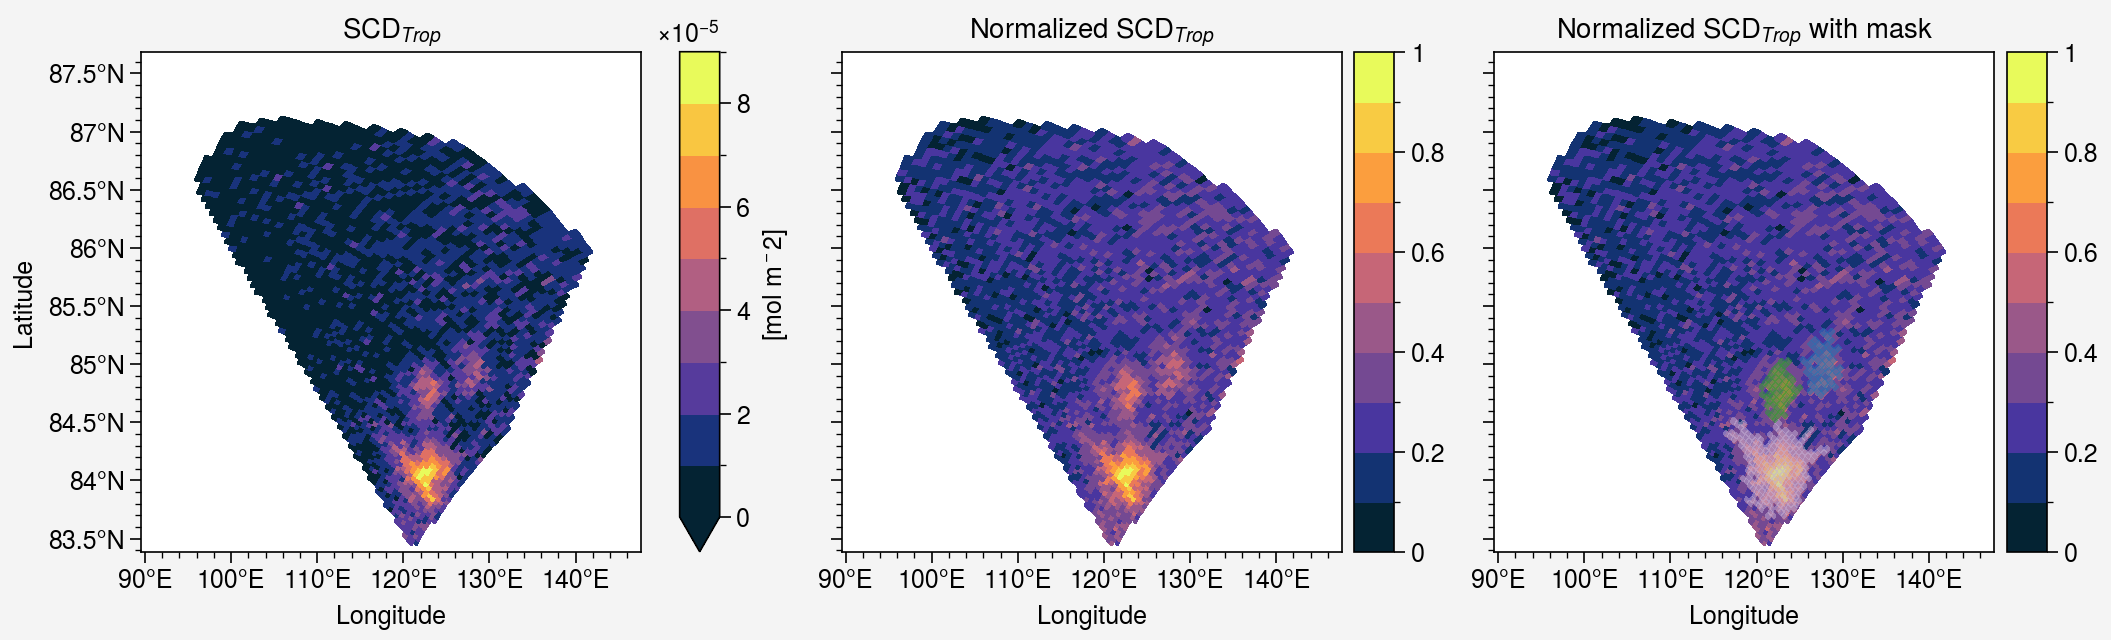

In [8]:
fig, axs = pplt.subplots(ncols=3, span=0)

scd_no2.plot(ax=axs[0], x='longitude', y='latitude', cmap='Thermal', vmin=0, cbar_kwargs=dict(label='[mol m$^-2$]'))
scd_no2_norm.plot(ax=axs[1], x='longitude', y='latitude', cmap='Thermal', cbar_kwargs=dict(label=''))
scd_no2_norm.plot(ax=axs[2], x='longitude', y='latitude', cmap='Thermal', cbar_kwargs=dict(label=''))
masks_no2.plot(ax=axs[2], x='longitude', y='latitude', cmap='tab20', add_colorbar=False, alpha=0.5)

# # add mask
# for i in range(masks_no2.shape[0]):
#     for j in range(masks_no2.shape[1]):
#         if not np.isnan(masks_no2[i, j]):
#             axs[2].add_patch(plt.Rectangle((masks_no2.coords['longitude'][i, j], masks_no2.coords['latitude'][i, j]), masks_no2.coords['longitude'].diff(dim='x').mean(), masks_no2.coords['latitude'].diff(dim='x').mean(), fc='none', ec='r', lw=0.3, clip_on=False))

axs.format(grid=False, xformatter='deglon', yformatter='deglat',
           xlabel='Longitude', ylabel='Latitude',
           title=['SCD$_{Trop}$','Normalized SCD$_{Trop}$','Normalized SCD$_{Trop}$ with mask'])

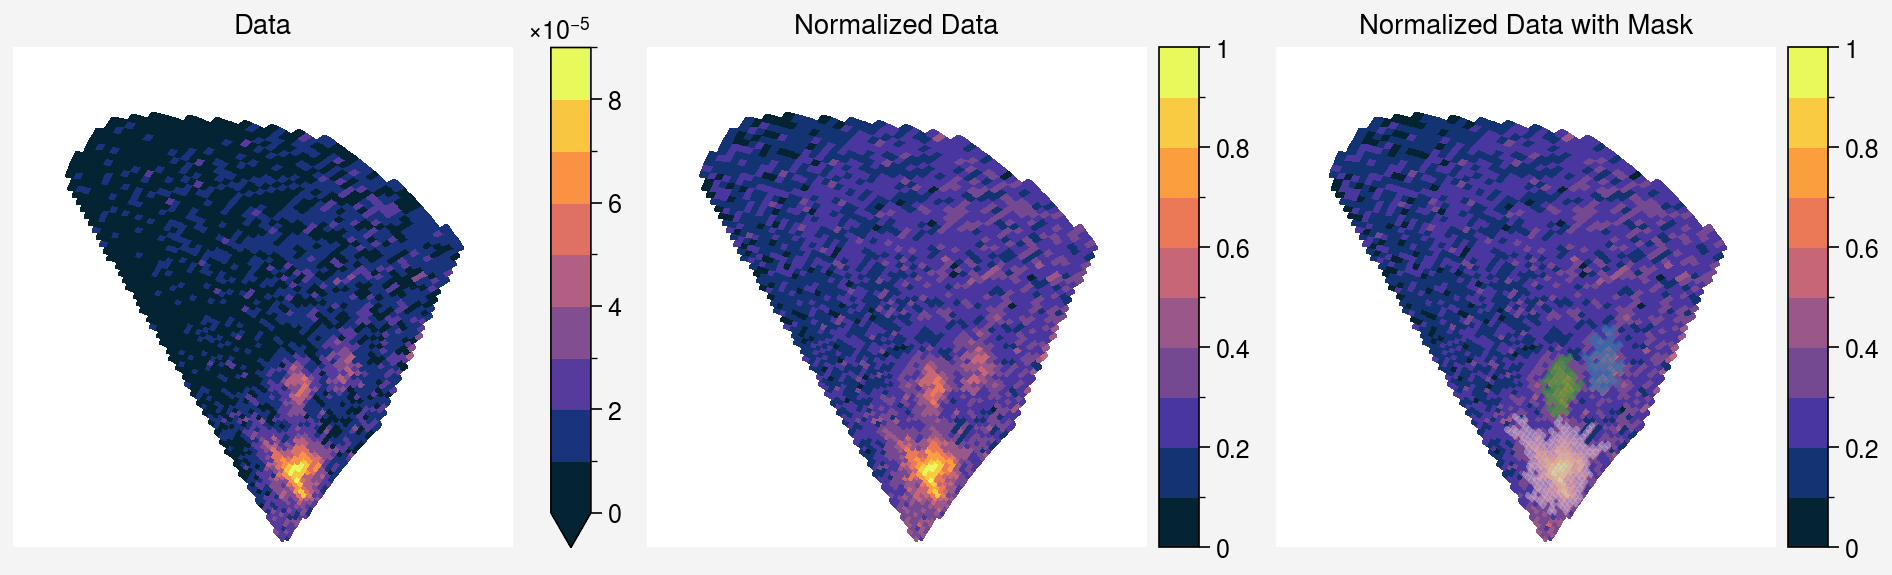

In [9]:
fig, axs = pplt.subplots(ncols=3, span=0)

scd_no2.plot(ax=axs[0], x='longitude', y='latitude', cmap='Thermal', vmin=0, cbar_kwargs=dict(label=''))
scd_no2_norm.plot(ax=axs[1], x='longitude', y='latitude', cmap='Thermal', cbar_kwargs=dict(label=''))
scd_no2_norm.plot(ax=axs[2], x='longitude', y='latitude', cmap='Thermal', cbar_kwargs=dict(label=''))
masks_no2.plot(ax=axs[2], x='longitude', y='latitude', cmap='tab20', add_colorbar=False, alpha=0.5)

# # add mask
# for i in range(masks_no2.shape[0]):
#     for j in range(masks_no2.shape[1]):
#         if not np.isnan(masks_no2[i, j]):
#             axs[2].add_patch(plt.Rectangle((masks_no2.coords['longitude'][i, j], masks_no2.coords['latitude'][i, j]), masks_no2.coords['longitude'].diff(dim='x').mean(), masks_no2.coords['latitude'].diff(dim='x').mean(), fc='none', ec='r', lw=0.3, clip_on=False))

axs.format(grid=False, linewidth=0,
           xlabel='', ylabel='', xticklabels=[''], yticklabels=[''],
           title=['Data','Normalized Data','Normalized Data with Mask'])